In [1]:
import sys
import seaborn as sns
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import rcParams
from collections import OrderedDict
import math
from matplotlib.lines import Line2D
from pylab import rcParams
from collections import Counter
from itertools import combinations
from shutil import copyfile
rcParams['figure.figsize'] = 25, 10
import numpy as np 
import random 
import datetime
import os 

np.random.seed(0)
random.seed(0)
now = datetime.datetime.now().strftime("%B_%d_%Y_%H_%M_%S")
workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)
from codes.otherfunctions.multiplot import highlight_cell
from codes.experimentclasses.MalonaldehydeAngles import MalonaldehydeAngles
from codes.otherfunctions.multirun import get_coeffs_reps
#from codes.otherfunctions.multirun import get_grads_reps_pca2
from codes.otherfunctions.multiplot import plot_betas, plot_betas2reorder
from codes.geometer.RiemannianManifold import RiemannianManifold
from codes.otherfunctions.get_dictionaries import get_atoms_4
from codes.otherfunctions.get_grads import get_grads
from codes.otherfunctions.multirun import get_support_recovery_lambda
from codes.otherfunctions.multirun import get_lower_interesting_lambda
from codes.otherfunctions.multirun import get_coeffs_and_lambdas
from codes.otherfunctions.multirun import get_support
from codes.otherfunctions.multiplot import plot_support_2d
from codes.otherfunctions.multiplot import plot_reg_path_ax_lambdasearch
from codes.otherfunctions.multiplot import plot_gs_v_dgnorm
from codes.otherfunctions.multirun import get_cosines
from codes.otherfunctions.multiplot import plot_dot_distributions
from codes.geometer.ShapeSpace import ShapeSpace
from codes.geometer.TangentBundle import TangentBundle
from codes.flasso.Replicate import Replicate
from codes.otherfunctions.multirun import get_olsnorm_and_supportsbrute
from codes.otherfunctions.multiplot import highlight_cell
from einops import rearrange
import dill as pickle

/Users/samsonkoelle/manifoldflasso_jmlr


In [2]:
#let us gaze into the malonaldehyde:
with open('/Users/samsonkoelle/Downloads/malonaldehyde_122620_n100pallnrep5replicates_small.pkl' ,
         'rb') as loader:
     replicates = pickle.load(loader)


#let us gaze into the malonaldehyde:
with open('/Users/samsonkoelle/Downloads/malonaldehyde_122620_n100pallnrep5results.pkl' ,
         'rb') as loader:
     results = pickle.load(loader)


In [3]:

#set parameters
n = 50000
#n = 10000 #number of data points to simulate
nsel = 100 #number of points to analyze with lasso
#itermax = 1000 #maximum iterations per lasso run
#tol = 1e-10 #convergence criteria for lasso
#lambdas = np.asarray([0,.01,.1,1,10,100], dtype = np.float16)#lambda values for lasso
#lambdas = np.asarray(np.hstack([np.asarray([0]),np.logspace(-3,1,11)]), dtype = np.float16)
n_neighbors = 1000 #number of neighbors in megaman
m = 3 #number of embedding dimensions (diffusion maps)
#diffusion_time = 1. #diffusion time controls gaussian kernel radius per gradients paper
diffusion_time = 1. #(yuchia suggestion)
dim = 2 #manifold dimension
dimnoise = 2
natoms = 9
cores = 3 #number of cores for parallel processing
cor = 0.0 #correlation for noise
var = 0.00001 #variance scaler for noise
ii = np.asarray([0, 0, 0, 1, 1, 1, 2, 2])
jj = np.asarray([4, 5, 1, 6, 7, 2, 3, 8])
#run experiment
#these are just for loading... probably not necessary
atoms4 = np.asarray([[4,0,1,2],[0,1,2,3],[3,2,1,8],[4,0,1,5]],dtype = int)
nreps = 5
lambda_max = 1
max_search = 30

folder = workingdirectory + '/Figures/malonaldehyde/' + now + 'n' + str(n) + 'nsel' + str(nsel) + 'nreps' + str(nreps)
#os.mkdir(folder)

#src = workingdirectory + '/codes/experiments/malonaldehyde_110120_nsel100_nreps25.py'
#filenamescript = folder + '/script.py'
#copyfile(src, filenamescript)

new_MN = True
new_grad = True
savename = 'malonaldehyde_110120'
savefolder = 'malonaldehyde'
loadfolder = 'malonaldehyde'
loadname = 'malonaldehyde_110120'
data_wd = '/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/'
if new_MN == True:
    experiment = MalonaldehydeAngles(dim, ii, jj,cores,atoms4)
    projector  = np.load(data_wd + '/untracked_data/chemistry_data/malonaldehydeangles022119_pca50_components.npy')
    experiment.M = experiment.load_data(data_wd)  # if noise == False then noise parameters are overriden
    experiment.Mpca = RiemannianManifold(np.load(data_wd + '/untracked_data/chemistry_data/malonaldehydeangles022119_pca50.npy'), dim)
    experiment.q = m
    experiment.m = m
    experiment.dimnoise = dimnoise
    experiment.projector = projector
    experiment.Mpca.geom = experiment.Mpca.compute_geom(diffusion_time, n_neighbors)
    experiment.N = experiment.Mpca.get_embedding3(experiment.Mpca.geom, m, diffusion_time, dim)


In [4]:
ii_mal = np.asarray([0, 0, 0, 1, 1, 1, 2, 2])
jj_mal = np.asarray([4, 5, 1, 6, 7, 2, 3, 8])
atoms4_mal, p = get_atoms_4(9,ii_mal,jj_mal)
atoms4_mal[3], atoms4_mal[11]


(array([5, 0, 1, 6]), array([7, 1, 2, 8]))

In [5]:
g1 = experiment.get_g_full_sub(experiment.M.data, atoms4_mal[3])
g2 = experiment.get_g_full_sub(experiment.M.data, atoms4_mal[11])

KeyboardInterrupt: 

In [ ]:
data = experiment.N.data

s = 100
alpha = .5
fig, axes = plt.subplots(6,6, figsize = (25,25))

for d in range(6):
    print(d)
    for e in range(6):
        if d != e:
            axes[d,e].scatter(experiment.Mpca.data[:,d],experiment.Mpca.data[:,e], s = .1, alpha = .1)
            axes[d,e].set_xticklabels([])
            axes[d,e].set_yticklabels([])
            axes[d,e].set_xticks([])
            axes[d,e].set_yticks([])
            
fig = plt.gcf()
fig.suptitle('Pairplot of top 6 ' + r'$\xi$' + ' coordinates in Malonaldehyde', fontsize=70)

plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/mal_xi_pairplot')
            #axes[d,e].set_axis_off()
#axes.set_   

In [ ]:
%matplotlib inline
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

fig, axs = plt.subplots(1,1, figsize = (15,10))

axs.set_axis_off()
data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]

ax = fig.add_subplot(1,1,1, projection='3d')

ax.scatter(x, y, z, c = g1, s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
ax.set_xlabel(r'$\phi_1$', fontsize = 60)
ax.set_ylabel(r'$\phi_2$', fontsize = 60)
ax.set_zlabel(r'$\phi_3$', fontsize = 60)

ax.set_title(r'$g_{1}$', fontsize = 80, color = 'orange')

xmin = np.float(np.format_float_positional(data[:, 0][selected_points].min(), precision=2, fractional=False))
xmax = np.float(np.format_float_positional(data[:, 0][selected_points].max(), precision=2, fractional=False))
ymin = np.float(np.format_float_positional(data[:, 1][selected_points].min(), precision=2, fractional=False))
ymax = np.float(np.format_float_positional(data[:, 1][selected_points].max(), precision=2, fractional=False))
zmin = np.float(np.format_float_positional(data[:, 2][selected_points].min(), precision=2, fractional=False))
zmax = np.float(np.format_float_positional(data[:, 2][selected_points].max(), precision=2, fractional=False))
ax.set_xticks([xmin, xmax])
ax.set_yticks([ymin, ymax])
ax.set_zticks([zmin, zmax])
ax.tick_params(labelsize=30)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/mal_groundtruth_g1')

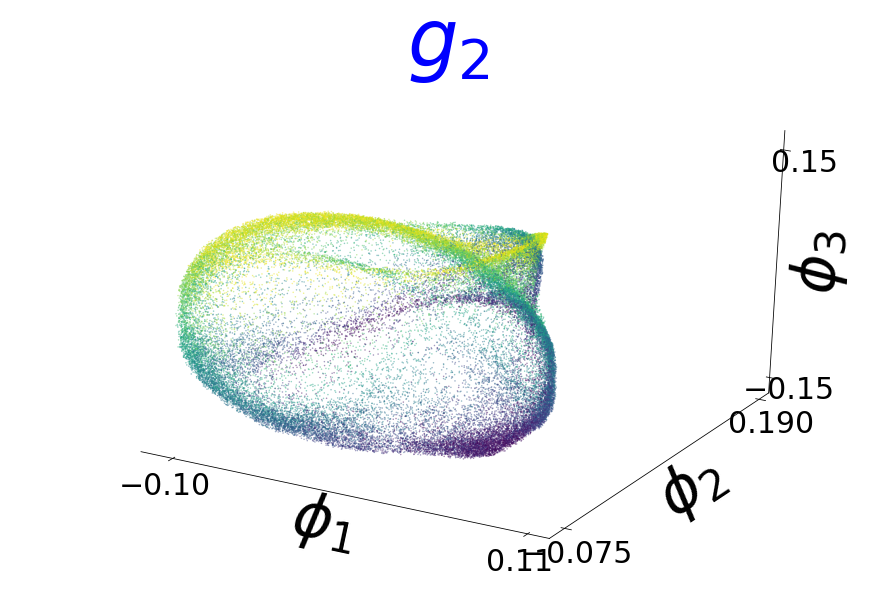

In [12]:
%matplotlib inline
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

fig, axs = plt.subplots(1,1, figsize = (15,10))

axs.set_axis_off()
data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]

ax = fig.add_subplot(1,1,1, projection='3d')

ax.scatter(x, y, z, c = g2, s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
ax.set_xlabel(r'$\phi_1$', fontsize = 60)
ax.set_ylabel(r'$\phi_2$', fontsize = 60)
ax.set_zlabel(r'$\phi_3$', fontsize = 60)
ax.set_title(r'$g_{2}$', fontsize = 80, color = 'blue')

xmin = np.float(np.format_float_positional(data[:, 0][selected_points].min(), precision=2, fractional=False))
xmax = np.float(np.format_float_positional(data[:, 0][selected_points].max(), precision=2, fractional=False))
ymin = np.float(np.format_float_positional(data[:, 1][selected_points].min(), precision=2, fractional=False))
ymax = np.float(np.format_float_positional(data[:, 1][selected_points].max(), precision=2, fractional=False))
zmin = np.float(np.format_float_positional(data[:, 2][selected_points].min(), precision=2, fractional=False))
zmax = np.float(np.format_float_positional(data[:, 2][selected_points].max(), precision=2, fractional=False))
ax.set_xticks([xmin, xmax])
ax.set_yticks([ymin, ymax])
ax.set_zticks([zmin, zmax])
ax.tick_params(labelsize=30)

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/mal_groundtruth_g2')

In [18]:
from codes.otherfunctions.get_dictionaries import get_all_atoms_4
atoms4 , p = get_all_atoms_4(9)
r = 0
rep = replicates[r]

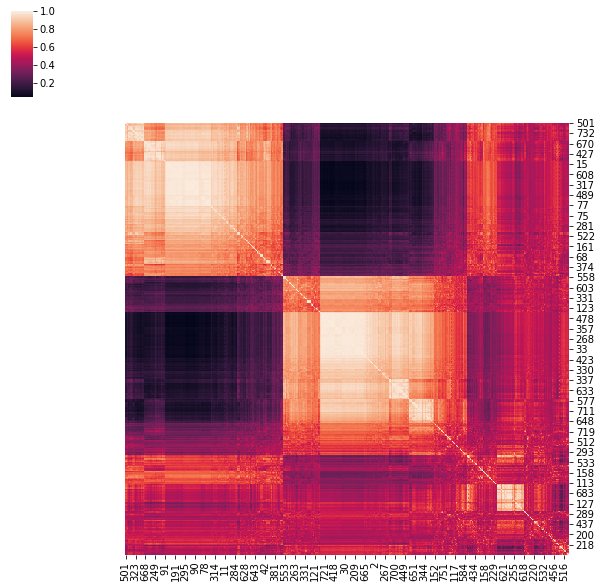

In [11]:



%matplotlib inline
clustermap = sns.clustermap(rep.cos)
clustermap.ax_row_dendrogram.set_visible(False)
clustermap.ax_col_dendrogram.set_visible(False)

In [6]:
for r in range(5):
    #r = 0 
    cs = rearrange(np.asarray(list(results[r][1].values())), 'l n p m -> l m n p')
    xaxis = np.asarray(np.asarray(list(results[r][1].keys())))
    xaxis_reorder = xaxis[xaxis.argsort()]
    cs_reorder = cs[xaxis.argsort()]
    xaxis_reorder = xaxis[xaxis.argsort()]
    replicates[r].cs = cs
    replicates[r].cs_reorder = cs_reorder
    replicates[r].xaxis_reorder = xaxis_reorder
    replicates[r].xaxis = xaxis

In [7]:
nreps = 5
sel_l = np.zeros(nreps, dtype = int)
for r in range(5):
    for l in range(replicates[r].cs_reorder.shape[0]):
        zeros = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[l] !=0.)[0]
        if len(zeros) == 2:
            sel_l[r] = l
            #print(np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[2] !=0.))

almost_sel = {}
sel = {}
for r in range(5):
    zeros = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[sel_l[r]-1] !=0.)[0]
    sel[r] = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[sel_l[r]] !=0.)[0]
    almost_sel[r] = zeros

In [8]:
def cosine_similarity(a, b):
    output = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return (output)

def get_kappa_s(dg_M):
    n = dg_M.shape[0]
    d= dg_M.shape[1]
    p = dg_M.shape[2]
    maxes = np.zeros(n)
    #coses_zerodiag = coses.copy()
    kappa_ij= np.zeros((n,p))
    for i in range(n):
        kappa_ij[i] = np.linalg.norm(dg_M[i], axis = 0)
    kappa_i = np.max(kappa_ij, axis = 1) / np.min(kappa_ij, axis = 1)
    kappa = np.max(kappa_i)    
    return(kappa)

def get_coses_full_ind(dg, ind):
    n = dg.shape[0]
    p = dg.shape[1]
    d = dg.shape[2]
    l = len(ind)
    coses = np.zeros((n, l, p))
    
    for i in range(n):
        #print(i)
        for j in range(l):
            for k in range(p):
                if ind[j] != k:
                    coses[i, j, k] = cosine_similarity(dg[i, ind[j], :], dg[i, k,:])  # sklearn.metrics.pairwise.cosine_similarity(X = np.reshape(dg[:,i,:], (1,d*n)),Y = np.reshape(dg[:,j,:], (1,d*n)))[0][0]
    # cos_summary = np.abs(coses).sum(axis = 0) / n
    #cos_summary = np.sum(coses ** 2, axis=0) / n
    return (coses)

def get_mu_full_ind(dg, ind):
    n = dg.shape[0]
    p = dg.shape[1]
    d = dg.shape[2]
    l = len(ind)
    coses = np.zeros((n, l, p))
    for i in range(n):
        #print(i)
        for j in range(l):
            for k in range(p):
                if ind[j] != k:
                    coses[i, j, k] = cosine_similarity(dg[i, ind[j], :], dg[i, k,:])  # sklearn.metrics.pairwise.cosine_similarity(X = np.reshape(dg[:,i,:], (1,d*n)),Y = np.reshape(dg[:,j,:], (1,d*n)))[0][0]
    # cos_summary = np.abs(coses).sum(axis = 0) / n
    #cos_summary = np.sum(coses ** 2, axis=0) / n
    return (coses.max())

def get_min_min(dg_M):
    n = dg_M.shape[0]
    d= dg_M.shape[1]
    p = dg_M.shape[2]
    maxes = np.zeros(n)
    #coses_zerodiag = coses.copy()
    kappa_ij= np.zeros((n,p))
    for i in range(n):
        kappa_ij[i] = np.linalg.norm(dg_M[i], axis = 0)
    min_min = np.min(kappa_ij)
    return(min_min)

def get_gamma_max(dg_M):
    output = np.sum(np.sum(dg_M**2, axis = 1), axis = 0).max()
    return(output)

# def get_cosines(self, dg):
def get_cosines_full(dg):
    n = dg.shape[0]
    p = dg.shape[1]
    d = dg.shape[2]
    coses = np.zeros((n, p, p))
    for i in range(n):
        #print(i)
        for j in range(p):
            for k in range(p):
                coses[i, j, k] = cosine_similarity(dg[i, j, :], dg[i, k,:])  # sklearn.metrics.pairwise.cosine_similarity(X = np.reshape(dg[:,i,:], (1,d*n)),Y = np.reshape(dg[:,j,:], (1,d*n)))[0][0]
    # cos_summary = np.abs(coses).sum(axis = 0) / n
    #cos_summary = np.sum(coses ** 2, axis=0) / n
    return (coses)

In [29]:

min_mins = np.zeros(5, dtype = np.float64)
mus = np.zeros(5, dtype = np.float64)
kappas = np.zeros(5, dtype = np.float64)
gamma_maxs = np.zeros(5, dtype = np.float64)
n = 100
for r in range(5):
    print(r)
    inds = sel[r]
    dg_M = replicates[r].dg_M
    min_mins[r]  = get_min_min(dg_M[:,:,inds]*n)
    mus[r] = get_mu_full_ind(np.swapaxes(dg_M,1,2)*n, inds)
    kappas[r] = get_kappa_s(replicates[r].dg_M[:,:,inds]*n)
    gamma_maxs[r] = get_gamma_max(dg_M[:,:,inds]*np.sqrt(n ))

    

0
1
2
3
4


In [32]:
import pandas as pd
df_mal = pd.DataFrame(np.asarray([np.mean(mus), np.sqrt(np.var(mus)), 
                    np.mean(kappas), np.sqrt(np.var(kappas)),
                    np.mean(gamma_maxs),np.sqrt(np.var(gamma_maxs)),
                    np.mean(min_mins),np.sqrt(np.var(min_mins))]).transpose()).transpose()
np.asarray(df_mal)

array([[9.99999999e-01, 2.01628481e-09, 2.20489465e+00, 5.89811663e-01,
        6.60191682e+01, 1.04445095e+00, 3.95515734e+00, 8.53646039e-01]])

In [15]:

def plot_reg_path_ax_lambdasearch_customcolors_norm(ax, coeffs, xaxis,fig, colors):
    p = coeffs.shape[3]
    q = coeffs.shape[1]
    gnames = np.asarray(list(range(p)), dtype=str)

    rcParams['axes.titlesize'] = 30
    plt.rc('text', usetex=True)

    normax = np.sqrt(np.sum(np.sum(np.sum(coeffs ** 2, axis=1), axis=1), axis=1).max())

    for j in range(p):
        toplot = np.linalg.norm(np.linalg.norm(coeffs[:, :, :, j], axis=2), axis=1)
        # axes[0].boxplot(toplot, positions=xaxis, showfliers=False, vert=True, widths=widths,medianprops=dict(linestyle=''))
        ax.plot(xaxis, toplot, 'go--', linewidth=5, markersize=0, alpha=1.,
                     color=colors[j], label=gnames[j])

    kkk = xaxis.copy()
    kkk.sort()

    # xupperindex = np.min(np.where(np.sum(np.sum(np.sum(coeffs**2, axis = 1), axis = 1), axis = 1) ==0)[0])

    #for k in range(1 + q):
    ax.tick_params(labelsize=50)
    ax.set_xscale('symlog')
    ax.set_yscale('symlog')
    ax.set_ylim(bottom=0, top=normax)
    # axes[k].set_xlim(left = 0, right = xaxis[xupperindex])
    #if (k == 0):
    tixx = np.hstack(
        [np.asarray([0]), 10 ** np.linspace(math.floor(np.log10(normax)), math.floor(np.log10(normax)) + 1, 2)])
#    if k != 0:
        # axes[k].set_yticks(tixx)
    #ax.set_ylabel(r"$\displaystyle \|\hat \beta_{j}\|_2$", fontsize = 70)
    #ax.set_xlabel(r"$\lambda  \sqrt{nm}$", fontsize = 70)
    #ylabel = r"$\displaystyle \|\hat \beta_{j}\|_2$"
    #ax.l
    #if k == 0:
    #ax.set_title("Combined", fontdict={'fontsize': 50})
    ax.grid(True, which="both", alpha=True)

def plot_watch3(to_plot, names, colors,ax):
    
    p = to_plot.shape[0]
    #fig, ax = plt.subplots(figsize = (15,15))
    #%matplotlib inline
    
    #fig, ax = plt.subplots(figsize = (15,15))
    theta = np.linspace(0, 2*np.pi, 10000)
    #cmap = plt.get_cmap('twilight_shifted',p)
    
    angles = np.linspace(0, 2*np.pi, p+1)
    
    radius = 1.

    a = radius*np.cos(theta)
    b = radius*np.sin(theta)

    #figure, axes = plt.subplots(figsize = (15,15))

    #axes.plot(a, b, color= 'gray')
    ax.scatter(a, b, color = 'gray', s= .2, alpha = .1)#, '-', color = 'gray')#, s= .1, alpha = .1)#, type = 'line')#,cmap=plt.get_cmap('twilight')) #'hsv','twilight_shifted

    #for i in range(to_plot.shape)
    if len(to_plot.shape) > 1:
        totes = np.sum(to_plot, axis = 0)
    else:
        totes = to_plot
        
    for j in range(p):
        print(np.cos(angles[j]), np.sin(angles[j]))#r'$test \frac{1}{}$'.format(g)
        ax.scatter(np.cos(angles[j]),np.sin(angles[j]),color=colors[j], marker  = 'x')
        ax.text( x = 1.1*np.cos(angles[j]),
                  y = 1.1*np.sin(angles[j]),
                  s = names[j],color=colors[j],
                  fontdict = {'fontsize' : 40},
                  horizontalalignment='center',
         verticalalignment='center')

        ax.text( x = .9*np.cos(angles[j]),y = .9*np.sin(angles[j]),s = str(totes[j] / nreps), fontdict = {'fontsize' : 30},
                  horizontalalignment='center',
         verticalalignment='center')



    for j in range(p):
        ax.scatter(np.cos(angles[j]),np.sin(angles[j]),color=colors[j], marker  = 'o', s = 100*totes[j] )

    if len(to_plot.shape) > 1:
        for i in range(p):
            for j in range(p):

                #point1 = [1, 2]
                #point2 = [3, 4]

                x_values = [np.cos(angles[j]), np.cos(angles[i])]
                #gather x-values

                y_values = [np.sin(angles[j]), np.sin(angles[i])]
                #gather y-values

                ax.plot(x_values, y_values,linewidth = to_plot[i,j], color = 'black')

                if to_plot[i,j] > 0 :
                    ax.text(x = np.mean(x_values),
                      y = np.mean(y_values),
                      s = str(to_plot[i,j] / nreps),
                      fontdict = {'fontsize' : 20})#,
                  #horizontalalignment='left',
                # verticalalignment='bottom')
                #axes.axline((x1, y1), (x2, y2))
    ax.set_aspect(1)
    ax.set_axis_off()

In [9]:
#subset

subset_l0 = np.unique(np.asarray(list(sel.values())))
psmallest = len(subset_l0)

to_plot_l0 = np.zeros((psmallest, psmallest))

#to_plot = np.zeros(np.repeat(p,d))

#supports = {}
nreps = 5
for r in range(nreps):
    #to_plot[sel]
    
    i_smallest = np.where(subset_l0 == sel[r][0])[0]
    print(sel[r][0], i_smallest)
    
    j_smallest = np.where(subset_l0 == sel[r][1])[0]
    print(sel[r][0], j_smallest)
    
    to_plot_l0[i_smallest,j_smallest] +=1
    to_plot_l0[j_smallest,i_smallest] +=1
    
names_l0 = np.zeros(len(subset_l0), dtype = object)
for s in range(len(subset_l0)):
    names_l0[s] = r"$g_{{{}}}$".format(subset_l0[s])

712 [0]
712 [2]
718 [1]
718 [2]
712 [0]
712 [3]
718 [1]
718 [2]
732 [2]
732 [3]


In [10]:
sel_total = almost_sel

#subset

subset = np.unique(np.concatenate(list(sel_total.values())))
psmallest = len(subset)

to_plot = np.zeros((psmallest, psmallest))

#to_plot = np.zeros(np.repeat(p,d))

#supports = {}
nreps = 5
for r in range(nreps):
    #to_plot[sel]
    
    i_smallest = np.where(subset == sel[r][0])[0]
    print(sel[r][0], i_smallest)
    
    j_smallest = np.where(subset == sel[r][1])[0]
    print(sel[r][0], j_smallest)
    
    to_plot[i_smallest,j_smallest] +=1
    to_plot[j_smallest,i_smallest] +=1
    
names = np.zeros(len(subset), dtype = object)
for s in range(len(subset)):
    names[s] = r"$g_{{{}}}$".format(subset[s])

cmap = plt.get_cmap('brg',len(subset))

colors_subset = np.zeros((len(subset),4))
for s in range(len(subset)):
    #colors_r0[s] = cmap.colors[np.where(subset == r0subset[s])[0]]
    colors_subset[s] = cmap(s)
    print(cmap(s))


712 [1]
712 [3]
718 [2]
718 [3]
712 [1]
712 [4]
718 [2]
718 [3]
732 [3]
732 [4]
(0.0, 0.0, 1.0, 1.0)
(0.5, 0.0, 0.5, 1.0)
(1.0, 0.0, 0.0, 1.0)
(0.5, 0.5, 0.0, 1.0)
(0.0, 1.0, 0.0, 1.0)


In [11]:
colors_l0 = np.zeros((len(subset_l0),4 ))
for s in range(len(subset_l0)):
    colors_l0[s] = colors_subset[np.where(subset == subset_l0[s])[0]]
    
colors_sub_l0 = np.zeros((4,5))


In [12]:
#def get_olsnorm_and_supportsbrute(experiment, replicates):
dim = 2
dnoise = 2
nreps = 5
nsel = 100
#p = 6

supports_brute = {}

for r in range(nreps):
    possebs= almost_sel[r]
    p = len(possebs)
    parameterizations_possible = np.asarray(list(combinations(range(p), dnoise)))
    nparameterizations_possible = parameterizations_possible.shape[0]
    penalties = np.zeros((nreps, nparameterizations_possible))
    #ols_norm = np.zeros((nreps, p, p))
    #subset
    brute_coeffs = np.zeros((nsel, nparameterizations_possible, 2, 3))
    orthogonality = np.zeros((nsel, nparameterizations_possible))
    for i in range(nsel):
        for j in range(nparameterizations_possible):
            brute_coeffs[i, j] = np.linalg.lstsq(np.swapaxes(replicates[r].dg_M[i, :,possebs[parameterizations_possible[j]]],0,1), replicates[r].df_M[i])[0]
            # orthogonality[i,j] = get_penalty(brute_coeffs[i,j])
    for j in range(nparameterizations_possible):
        penalties[r, j] = experiment.compute_penalty2(np.expand_dims(brute_coeffs[:, j], 0))
    print('here')
    sbr = parameterizations_possible[penalties[r, :].argmin()]
    supports_brute[r] = possebs[sbr]
#return (ols_norm, supports_brute)


here
here
here
here
here


/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/ipykernel_launcher.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [13]:
#subset

subset = np.unique(np.concatenate(list(almost_sel.values())))
psmallest = len(subset)

to_plot_brute = np.zeros((psmallest, psmallest))

#to_plot = np.zeros(np.repeat(p,d))

#supports = {}
nreps = 5
for r in range(nreps):
    #to_plot[sel]
    
    i_smallest = np.where(subset == supports_brute[r][0])[0]
    print(sel[r][0], i_smallest)
    
    j_smallest = np.where(subset == supports_brute[r][1])[0]
    print(sel[r][0], j_smallest)
    
    to_plot_brute[i_smallest,j_smallest] +=1
    to_plot_brute[j_smallest,i_smallest] +=1
    
names = np.zeros(len(subset), dtype = object)
for s in range(len(subset)):
    names[s] = r"$g_{{{}}}$".format(subset[s])



712 [2]
712 [3]
718 [0]
718 [3]
712 [1]
712 [4]
718 [2]
718 [3]
732 [2]
732 [4]


In [16]:
sel

{0: array([712, 732]),
 1: array([718, 732]),
 2: array([712, 738]),
 3: array([718, 732]),
 4: array([732, 738])}

In [15]:
supports_brute

{0: array([718, 732]),
 1: array([691, 732]),
 2: array([712, 738]),
 3: array([718, 732]),
 4: array([718, 738])}

In [14]:
names

array(['$g_{691}$', '$g_{712}$', '$g_{718}$', '$g_{732}$', '$g_{738}$'],
      dtype=object)

In [22]:
subset = np.unique(np.concatenate(list(sel_total.values())))
p = subset.shape[0]
to_plot_brute = np.zeros((p,p))
for r in range(5):
    i_sub = np.where(subset == supports_brute[r][0])
    j_sub = np.where(subset == supports_brute[r][1])
    to_plot_brute[i_sub,j_sub] += 1.
    to_plot_brute[j_sub,i_sub] += 1.

In [46]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command


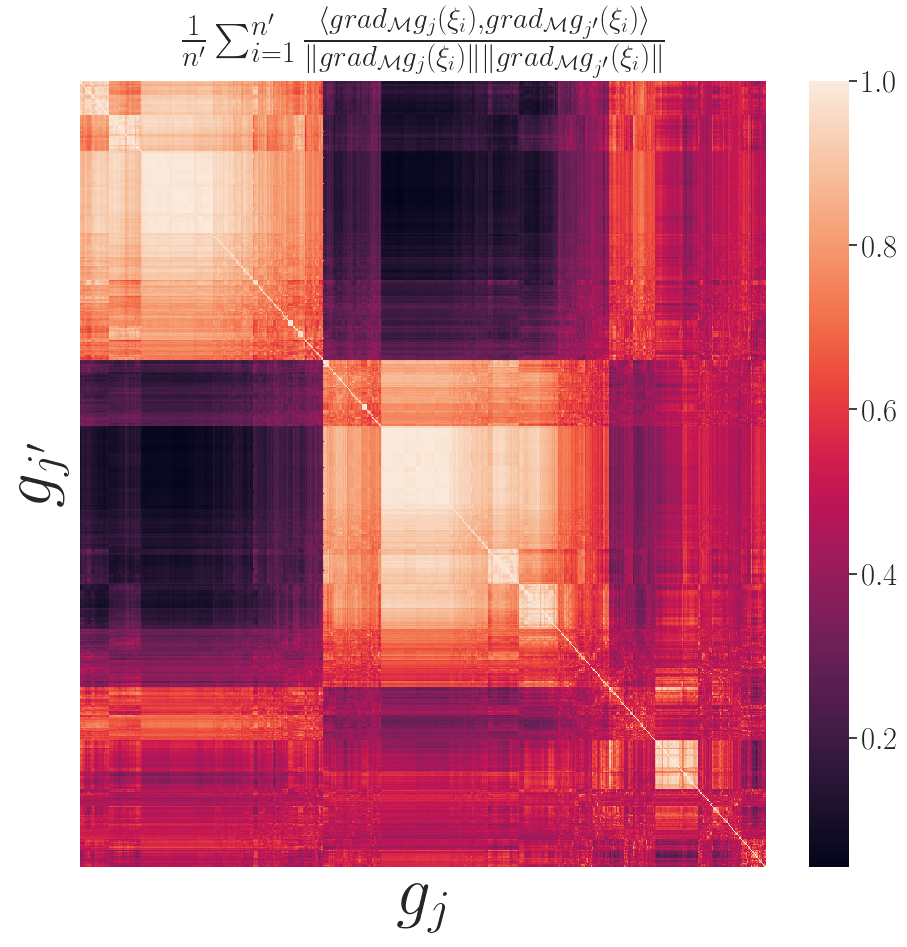

In [47]:
#figure a

sns.set(font_scale=2)
f, axarr = plt.subplots(1,1, figsize=(10, 10))
#[ax.set_axis_off() for ax in axarr.ravel()]

sns.heatmap(rep.cos[clustermap.dendrogram_col.reordered_ind][:,clustermap.dendrogram_col.reordered_ind], ax = axarr)
axarr.set_title(r"$\frac{1}{n'} \sum_{i = 1}^{n'} \frac{\langle grad_{\mathcal M} g_j (\xi_i) ,grad_{\mathcal M} g_{j'} (\xi_i)\rangle}{\|grad_{\mathcal M} g_j (\xi_i) \| \| grad_{\mathcal M} g_{j'}(\xi_i) \|} $" ,
                fontsize = 30)
axarr.set_xticklabels([])
axarr.set_yticklabels([])
axarr.set_xticks([])
axarr.set_yticks([])
axarr.set_xlabel(r'$g_j$', fontsize= 50)
axarr.set_ylabel(r"$g_{j'}$", fontsize= 50)
plt.tight_layout()
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/mal_fulldict_cosines')
#plt.setp(axarr.get_legend().get_texts(), fontsize='22')

In [ ]:
f, axarr = plt.subplots(figsize=(10, 10))
plot_watch3(to_plot_l0, names=names_l0, colors=colors_l0, ax = axarr)
axarr.set_title('Estimated Supports', fontsize=  40)
plt.tight_layout()
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/mal_fulldict_estimatedsupports')

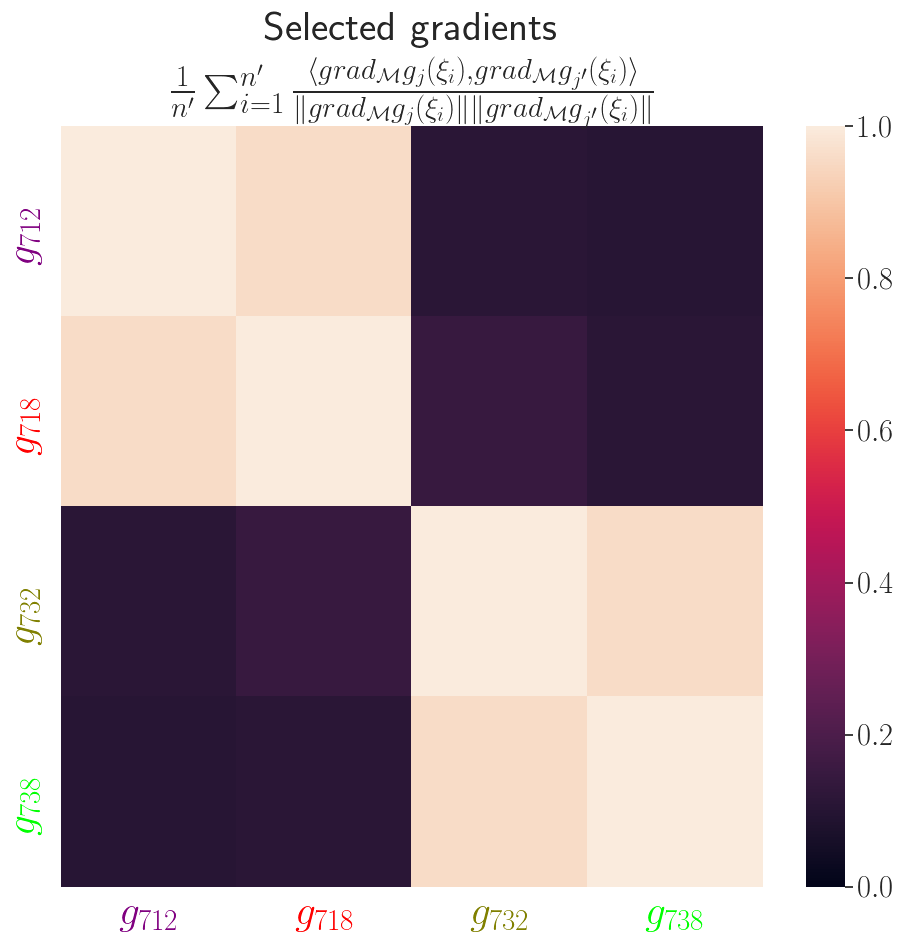

In [48]:
sns.set(font_scale=2)
f, axarr = plt.subplots(figsize=(10, 10))
cuz_l0 = get_cosines(np.swapaxes(replicates[0].dg_M[:,:,subset_l0], 1,2))
sns.heatmap(cuz_l0, yticklabels = names_l0, xticklabels = names_l0, ax = axarr, vmin = 0., vmax = 1.)
axarr.set_xticklabels(axarr.get_xmajorticklabels(), fontsize = 30)
axarr.set_yticklabels(axarr.get_ymajorticklabels(), fontsize = 30)
for xtick, color in zip(axarr.get_xticklabels(), colors_l0):
    xtick.set_color(color)
for ytick, color in zip(axarr.get_yticklabels(), colors_l0):
    ytick.set_color(color)
axarr.set_title('Selected gradients \n' + r"$\frac{1}{n'} \sum_{i = 1}^{n'} \frac{\langle grad_{\mathcal M} g_j (\xi_i) ,grad_{\mathcal M} g_{j'} (\xi_i)\rangle}{\|grad_{\mathcal M} g_j (\xi_i) \| \| grad_{\mathcal M} g_{j'}(\xi_i) \|} $" ,
                fontsize = 30)
plt.tight_layout()
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/mal_fulldict_estimatedsupport_cosines')

In [42]:

r= 0
colors = np.zeros((756,4))
colors[:,3] = 1

#colors[r0subset] = colors_r0
colors[subset] = colors_subset

cs = rearrange(np.asarray(list(results[r][1].values())), 'l n p m -> l m n p')
xaxis = np.asarray(np.asarray(list(results[r][1].keys())))
xaxis_reorder = xaxis[xaxis.argsort()]
cs_reorder = cs[xaxis.argsort()]
xaxis_reorder = xaxis[xaxis.argsort()]
replicates[r].cs = cs
replicates[r].cs_reorder = cs_reorder
replicates[r].xaxis_reorder = xaxis_reorder
replicates[r].xaxis = xaxis


In [51]:
mpl.style.use('default')

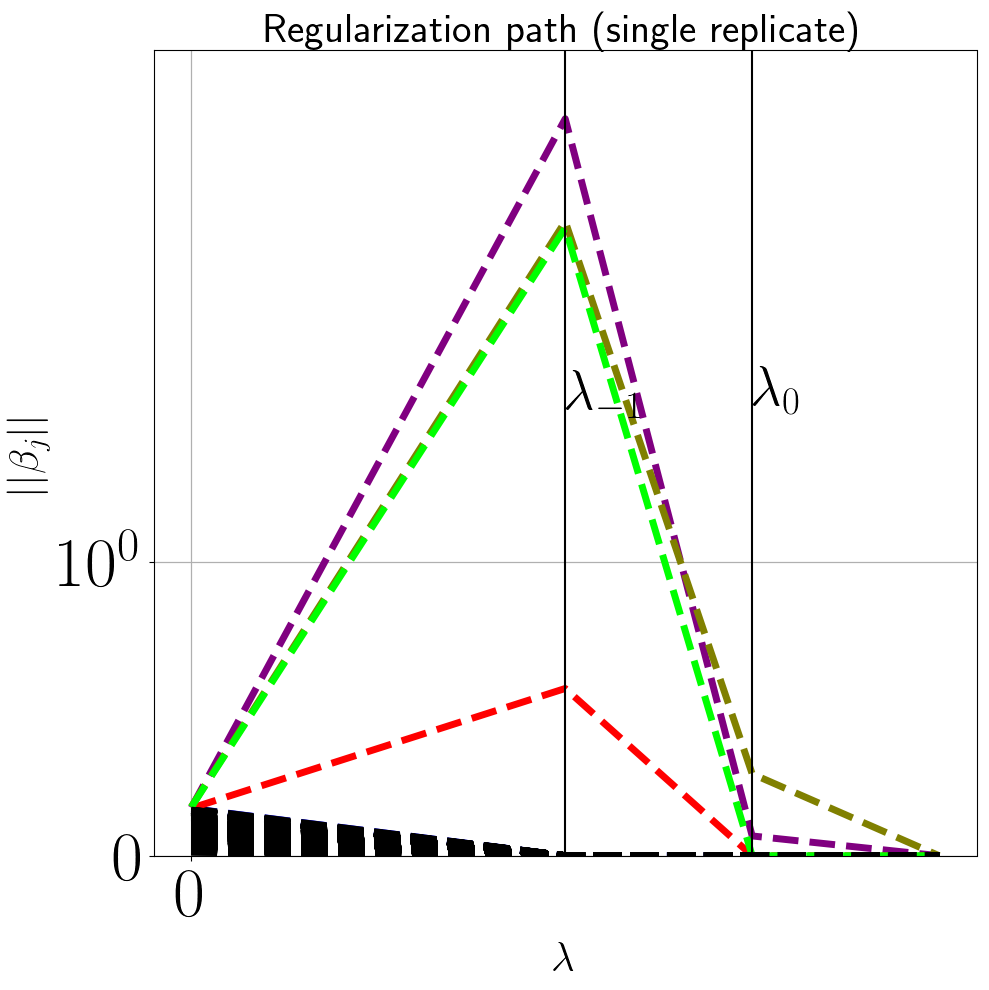

In [54]:
f, axarr = plt.subplots(1,1,figsize=(10, 10))
#axarr.set_axis_off() 
#mpl.style.use('default')
plot_reg_path_ax_lambdasearch_customcolors_norm(axarr, cs_reorder, xaxis_reorder * np.sqrt(3 * 5), f,colors)#axes_all[0].imshow(asdf)
axarr.set_xlabel(r'$\lambda$', fontsize = 30)
axarr.set_ylabel(r'$||\beta_j||$', fontsize = 30)

axarr.axvline(xaxis_reorder[1] * np.sqrt(3 * 5), color = 'black')
axarr.text(xaxis_reorder[1] * np.sqrt(3 * 5), 1.5, r'$\lambda_{-1}$', fontsize = 40)
axarr.axvline(xaxis_reorder[2] * np.sqrt(3 * 5), color = 'black')
axarr.text(xaxis_reorder[2] * np.sqrt(3 * 5), 1.5, r'$\lambda_{0}$', fontsize = 40)
axarr.set_title('Regularization path (single replicate)')
plt.tight_layout()
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/mal_fulldict_replicate')

#axarr.patch.set_facecolor('None')

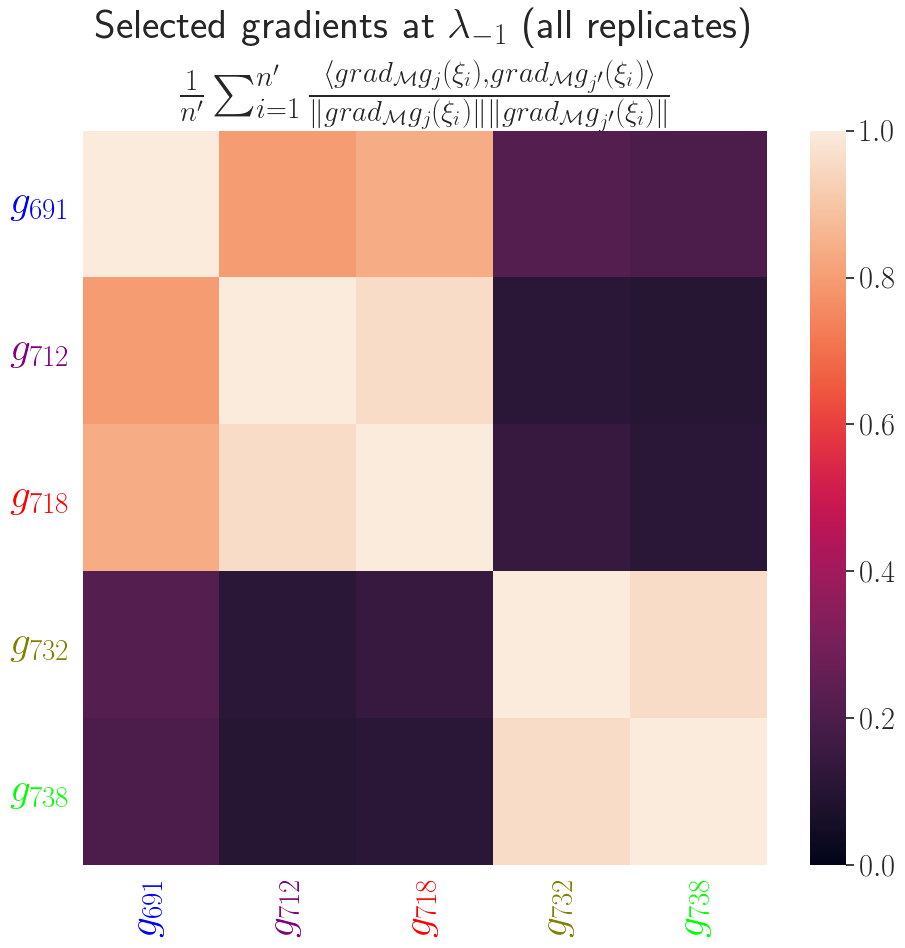

In [45]:
sns.set(font_scale=2)
f, axarr = plt.subplots(1,1,figsize=(10, 10))
cuz = get_cosines(np.swapaxes(replicates[0].dg_M[:,:,subset], 1,2))
sns.heatmap(cuz, yticklabels = names, xticklabels = names, ax = axarr, vmin = 0., vmax = 1.)
axarr.set_xticklabels(axarr.get_xmajorticklabels(), fontsize = 30)
axarr.set_yticklabels(axarr.get_ymajorticklabels(), fontsize = 30)
for xtick, color in zip(axarr.get_xticklabels(), colors_subset):
    xtick.set_color(color)
for ytick, color in zip(axarr.get_yticklabels(), colors_subset):
    ytick.set_color(color)
#axarr.set_title('Cosines of selected gradients at \n'  + r"$\lambda_{-1}$" + ' (all replicates)')
axarr.set_title('Selected gradients at ' + r'$\lambda_{-1}$' + '  (all replicates) \n' + r"$\frac{1}{n'} \sum_{i = 1}^{n'} \frac{\langle grad_{\mathcal M} g_j (\xi_i) ,grad_{\mathcal M} g_{j'} (\xi_i)\rangle}{\|grad_{\mathcal M} g_j (\xi_i) \| \| grad_{\mathcal M} g_{j'}(\xi_i) \|} $" ,
                fontsize = 30)
axarr.set_xticklabels(axarr.get_xmajorticklabels(), fontsize = 30, rotation = 90)
axarr.set_yticklabels(axarr.get_ymajorticklabels(), fontsize = 30, rotation = 0)
plt.tight_layout()
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/mal_fulldict_replicate_cosinelm1')

1.0 0.0
0.30901699437494745 0.9510565162951535
-0.8090169943749473 0.5877852522924732
-0.8090169943749475 -0.587785252292473
0.30901699437494723 -0.9510565162951536


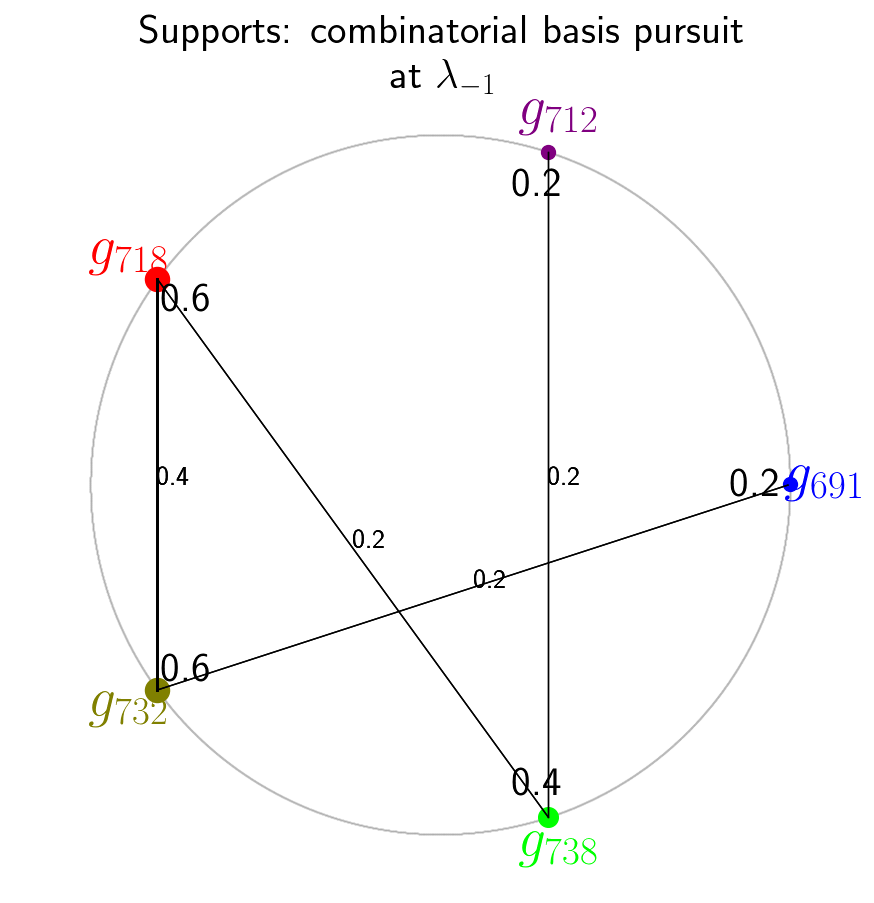

In [58]:
f, axarr = plt.subplots(1,1,figsize=(10, 10))

plot_watch3(to_plot_brute, names=names, colors=colors_subset, ax = axarr)
axarr.set_title('Supports: combinatorial basis pursuit \n at ' + r'$\lambda_{-1}$' , fontsize=  30)
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/mal_fulldict_lm1_brute')

In [19]:
g_mf = np.zeros((5,2,50000))
for r in range(5):
    for o in range(2):
        print(o)
        g_mf[r,o] =  experiment.get_g_full_sub(experiment.M.data, atoms4[sel[r][o]])

0
1
0
1
0
1
0
1
0
1


In [35]:
mpl.style.use('default')

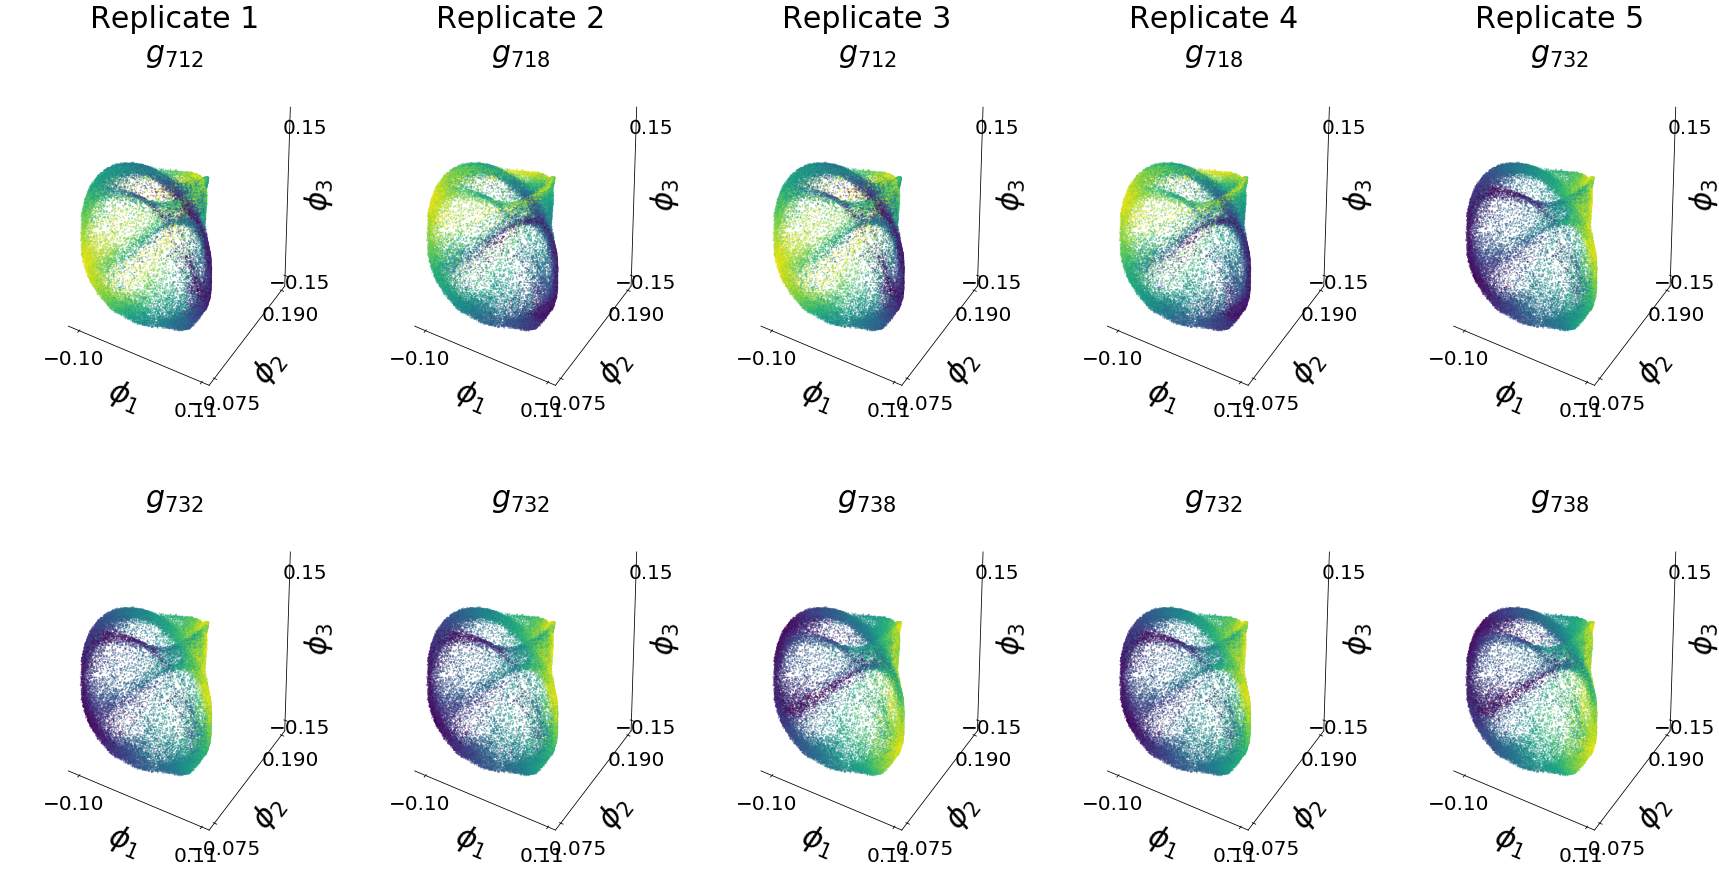

In [20]:
%matplotlib inline
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

fig, axs = plt.subplots(2,5, figsize = (30,15))

for r in range(5):
    for o in range(2):
        axs[o,r].set_axis_off()
data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]
for r in range(5):
    for o in range(2):
        ax = fig.add_subplot(2,5, o*5 + r + 1, projection='3d')
        #fig = plt.figure(figsize=(15,10))
        #ax = fig.add_subplot(1, 1, 1, projection='3d')
        ax.scatter(x, y, z, c = g_mf[r,o], s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
        ax.set_xlabel(r'$\phi_1$', fontsize = 30)
        ax.set_ylabel(r'$\phi_2$', fontsize = 30)
        ax.set_zlabel(r'$\phi_3$', fontsize = 30)
        
        if o ==0:
            ax.set_title('Replicate ' + str(r+1) + '\n' + r'$g_{{{}}}$'.format(sel[r][0]), fontsize = 30)
        if o == 1:
            ax.set_title(r'$g_{{{}}}$'.format(sel[r][1]), fontsize = 30)
        #ax.set_axis_off()
        xmin = np.float(np.format_float_positional(data[:, 0][selected_points].min(), precision=2, fractional=False))
        xmax = np.float(np.format_float_positional(data[:, 0][selected_points].max(), precision=2, fractional=False))
        ymin = np.float(np.format_float_positional(data[:, 1][selected_points].min(), precision=2, fractional=False))
        ymax = np.float(np.format_float_positional(data[:, 1][selected_points].max(), precision=2, fractional=False))
        zmin = np.float(np.format_float_positional(data[:, 2][selected_points].min(), precision=2, fractional=False))
        zmax = np.float(np.format_float_positional(data[:, 2][selected_points].max(), precision=2, fractional=False))
        ax.set_xticks([xmin, xmax])
        ax.set_yticks([ymin, ymax])
        ax.set_zticks([zmin, zmax])
        ax.tick_params(labelsize=20)

        ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        # make the grid lines transparent
        ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)    
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/mal_full_sup_mflasso')

1.0 0.0
6.123233995736766e-17 1.0
-1.0 1.2246467991473532e-16
-1.8369701987210297e-16 -1.0
1.0 0.0
0.30901699437494745 0.9510565162951535
-0.8090169943749473 0.5877852522924732
-0.8090169943749475 -0.587785252292473
0.30901699437494723 -0.9510565162951536


[Text(0, 0.5, '$g_{691}$'),
 Text(0, 1.5, '$g_{712}$'),
 Text(0, 2.5, '$g_{718}$'),
 Text(0, 3.5, '$g_{732}$'),
 Text(0, 4.5, '$g_{738}$')]

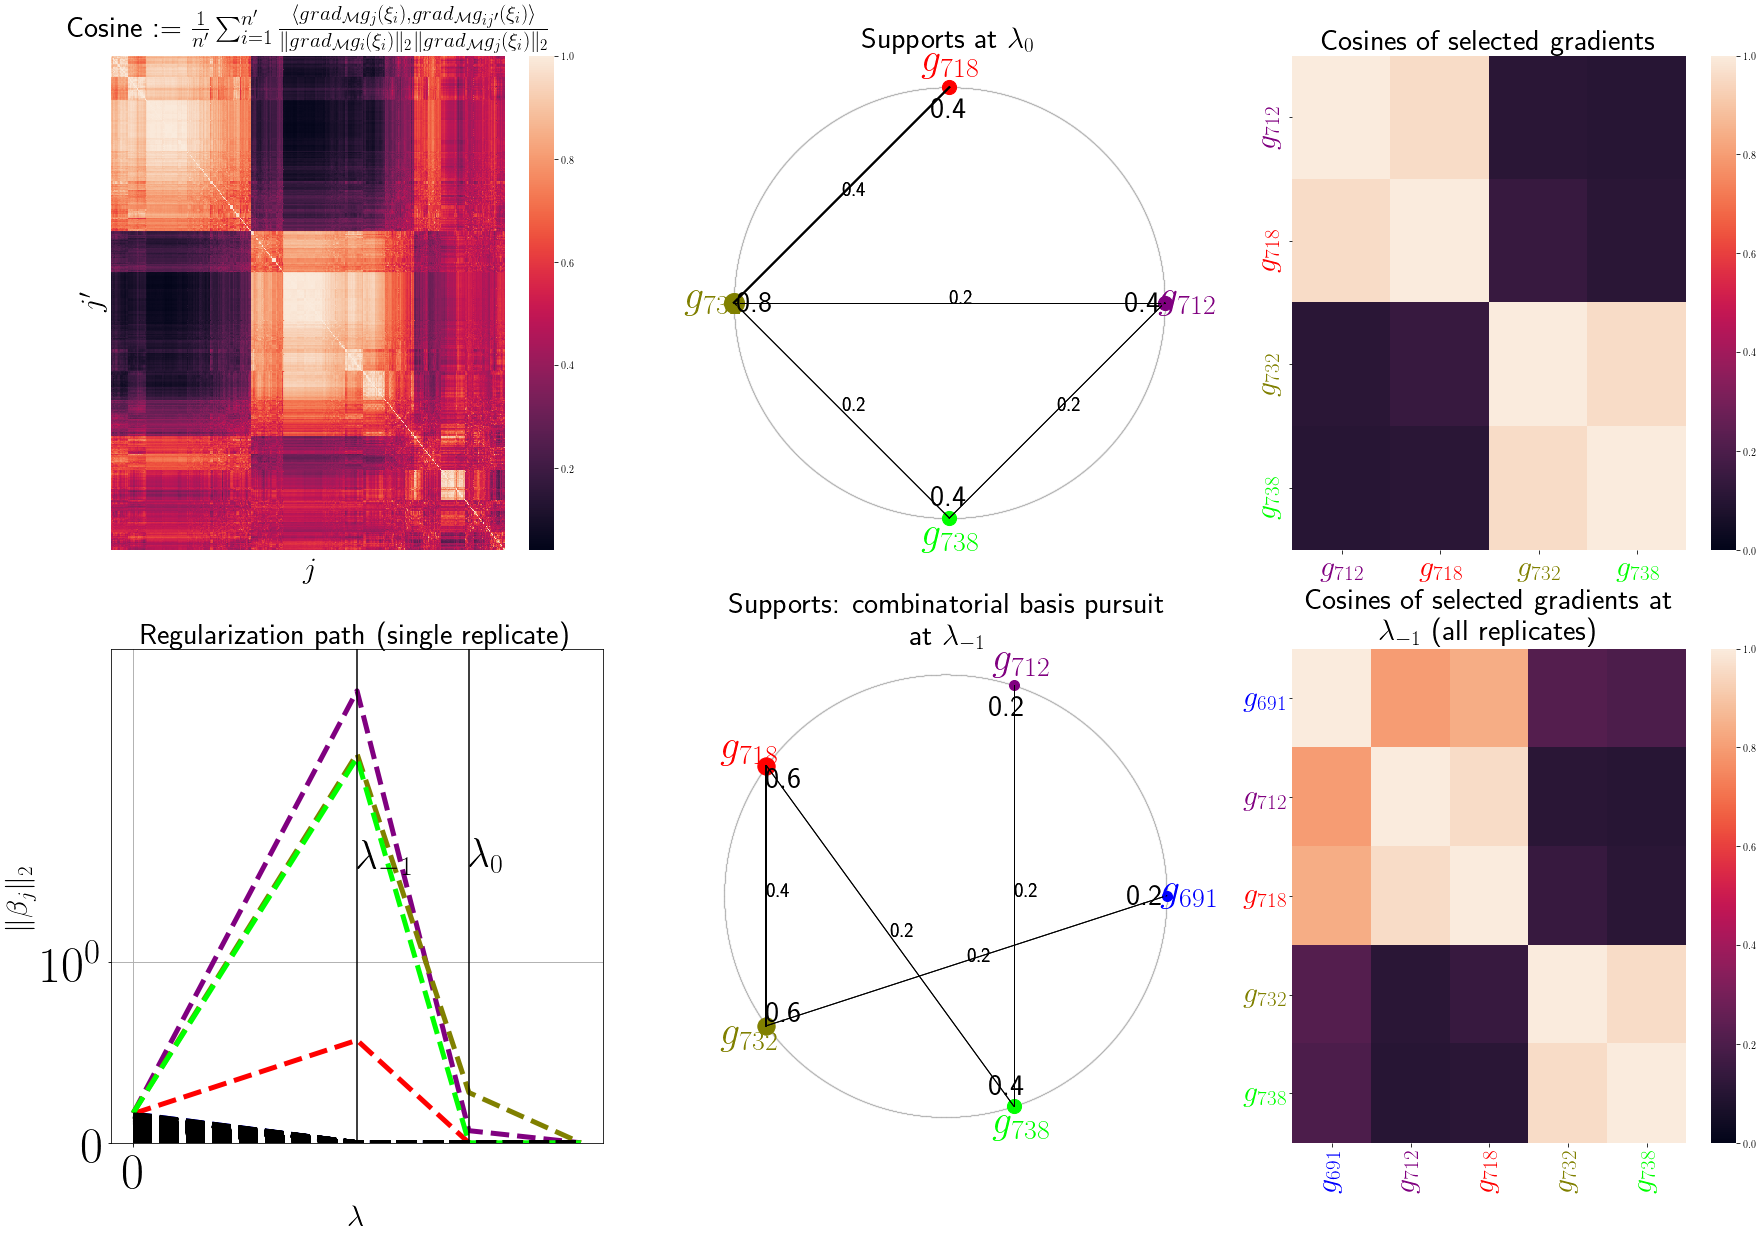

In [26]:
f, axarr = plt.subplots(2,3, figsize=(30, 20))
#[ax.set_axis_off() for ax in axarr.ravel()]

sns.heatmap(rep.cos[clustermap.dendrogram_col.reordered_ind][:,clustermap.dendrogram_col.reordered_ind], ax = axarr[0,0])
axarr[0,0].set_title('Cosine := ' + r"$\frac{1}{n'} \sum_{i = 1}^{n'} \frac{\langle grad_{\mathcal M} g_j (\xi_i) ,grad_{\mathcal M} g_{ij'} (\xi_i)\rangle}{\|grad_{\mathcal M} g_i (\xi_i) \|_2 \| grad_{\mathcal M} g_j(\xi_i) \|_2} $" ,
                fontsize = 30)
axarr[0,0].set_xticklabels([])
axarr[0,0].set_yticklabels([])
axarr[0,0].set_xticks([])
axarr[0,0].set_yticks([])
axarr[0,0].set_xlabel(r'$j$', fontsize= 30)
axarr[0,0].set_ylabel(r"$j'$", fontsize= 30)

plot_watch3(to_plot_l0, names=names_l0, colors=colors_l0, ax = axarr[0,1])
axarr[0,1].set_title('Supports at ' + r'$\lambda_0$', fontsize=  30)

cuz_l0 = get_cosines(np.swapaxes(replicates[0].dg_M[:,:,subset_l0], 1,2))
sns.heatmap(cuz_l0, yticklabels = names_l0, xticklabels = names_l0, ax = axarr[0,2], vmin = 0., vmax = 1.)
axarr[0,2].set_xticklabels(axarr[0,2].get_xmajorticklabels(), fontsize = 30)
axarr[0,2].set_yticklabels(axarr[0,2].get_ymajorticklabels(), fontsize = 30)
for xtick, color in zip(axarr[0,2].get_xticklabels(), colors_l0):
    xtick.set_color(color)
for ytick, color in zip(axarr[0,2].get_yticklabels(), colors_l0):
    ytick.set_color(color)
axarr[0,2].set_title('Cosines of selected gradients', fontsize = 30)

r= 0
colors = np.zeros((756,4))
colors[:,3] = 1

#colors[r0subset] = colors_r0
colors[subset] = colors_subset

cs = rearrange(np.asarray(list(results[r][1].values())), 'l n p m -> l m n p')
xaxis = np.asarray(np.asarray(list(results[r][1].keys())))
xaxis_reorder = xaxis[xaxis.argsort()]
cs_reorder = cs[xaxis.argsort()]
xaxis_reorder = xaxis[xaxis.argsort()]
replicates[r].cs = cs
replicates[r].cs_reorder = cs_reorder
replicates[r].xaxis_reorder = xaxis_reorder
replicates[r].xaxis = xaxis

plot_reg_path_ax_lambdasearch_customcolors_norm(axarr[1,0], cs_reorder, xaxis_reorder * np.sqrt(3 * 5), f,colors)#axes_all[0].imshow(asdf)
axarr[1,0].set_xlabel(r'$\lambda$', fontsize = 30)
axarr[1,0].set_ylabel(r'$\|\beta_j\|_2$', fontsize = 30)

axarr[1,0].axvline(xaxis_reorder[1] * np.sqrt(3 * 5), color = 'black')
axarr[1,0].text(xaxis_reorder[1] * np.sqrt(3 * 5), 1.5, r'$\lambda_{-1}$', fontsize = 40)
axarr[1,0].axvline(xaxis_reorder[2] * np.sqrt(3 * 5), color = 'black')
axarr[1,0].text(xaxis_reorder[2] * np.sqrt(3 * 5), 1.5, r'$\lambda_{0}$', fontsize = 40)
axarr[1,0].set_title('Regularization path (single replicate)')

plot_watch3(to_plot_brute, names=names, colors=colors_subset, ax = axarr[1,1])
axarr[1,1].set_title('Supports: combinatorial basis pursuit \n at ' + r'$\lambda_{-1}$' , fontsize=  30)

cuz = get_cosines(np.swapaxes(replicates[0].dg_M[:,:,subset], 1,2))
sns.heatmap(cuz, yticklabels = names, xticklabels = names, ax = axarr[1,2], vmin = 0., vmax = 1.)
axarr[1,2].set_xticklabels(axarr[1,2].get_xmajorticklabels(), fontsize = 30)
axarr[1,2].set_yticklabels(axarr[1,2].get_ymajorticklabels(), fontsize = 30)
for xtick, color in zip(axarr[1,2].get_xticklabels(), colors_subset):
    xtick.set_color(color)
for ytick, color in zip(axarr[1,2].get_yticklabels(), colors_subset):
    ytick.set_color(color)
axarr[1,2].set_title('Cosines of selected gradients at \n'  + r"$\lambda_{-1}$" + ' (all replicates)')
axarr[1,2].set_xticklabels(axarr[1,2].get_xmajorticklabels(), fontsize = 30, rotation = 90)
axarr[1,2].set_yticklabels(axarr[1,2].get_ymajorticklabels(), fontsize = 30, rotation = 0)
#plt.savefig('mal_fulldict')

In [28]:
names_l0

array(['$g_{712}$', '$g_{718}$', '$g_{732}$', '$g_{738}$'], dtype=object)

In [32]:
g_mf = np.zeros((5,2,50000))
for r in range(5):
    for o in range(2):
        print(o)
        g_mf[r,o] =  experiment.get_g_full_sub(experiment.M.data, atoms4[sel[r][o]])

0
1
0
1
0
1
0
1
0
1


In [33]:
g_brute = np.zeros((5,2,50000))
for r in range(5):
    for o in range(2):
        print(o)
        g_brute[r,o] =  experiment.get_g_full_sub(experiment.M.data, atoms4[supports_brute[r][o]])

0
1
0
1
0
1
0
1
0
1


In [43]:
supports_brute

{0: array([718, 732]),
 1: array([691, 732]),
 2: array([712, 738]),
 3: array([718, 732]),
 4: array([718, 738])}

In [36]:
sel

{0: array([712, 732]),
 1: array([718, 732]),
 2: array([712, 738]),
 3: array([718, 732]),
 4: array([732, 738])}

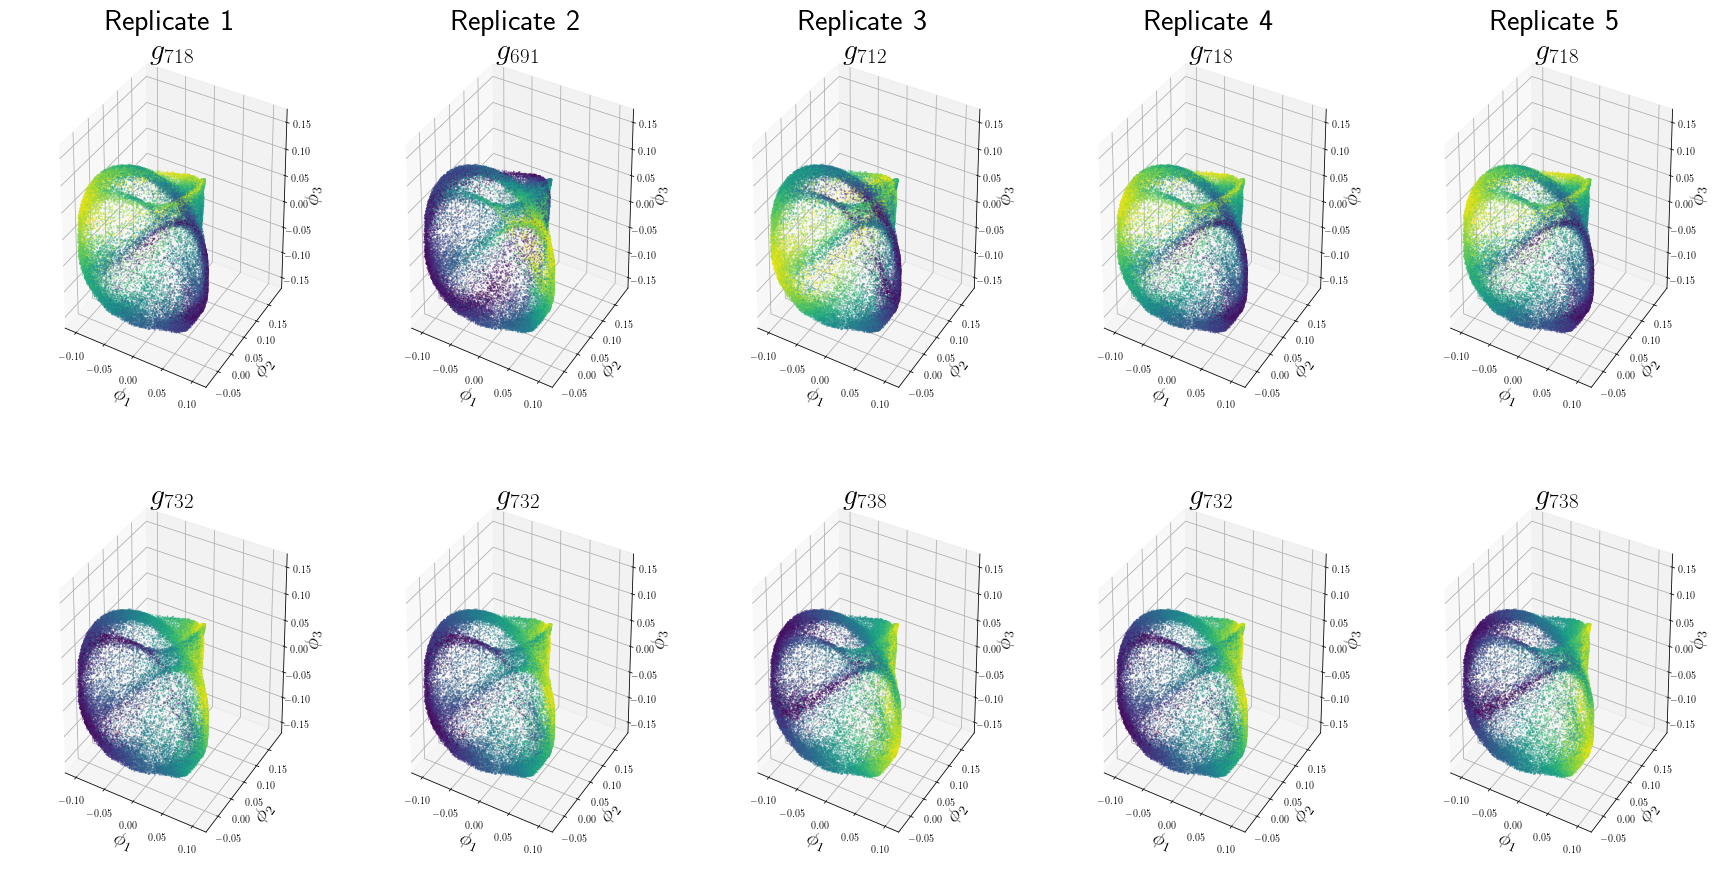

In [44]:
%matplotlib inline
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

fig, axs = plt.subplots(2,5, figsize = (30,15))

for r in range(5):
    for o in range(2):
        axs[o,r].set_axis_off()
data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]
for r in range(5):
    for o in range(2):
        ax = fig.add_subplot(2,5, o*5 + r + 1, projection='3d')
        #fig = plt.figure(figsize=(15,10))
        #ax = fig.add_subplot(1, 1, 1, projection='3d')
        ax.scatter(x, y, z, c = g_brute[r,o], s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
        ax.set_xlabel(r'$\phi_1$', fontsize = 20)
        ax.set_ylabel(r'$\phi_2$', fontsize = 20)
        ax.set_zlabel(r'$\phi_3$', fontsize = 20)
        
        if o ==0:
            ax.set_title('Replicate ' + str(r+1) + '\n' + r'$g_{{{}}}$'.format(supports_brute[r][0]))
        if o == 1:
            ax.set_title(r'$g_{{{}}}$'.format(supports_brute[r][1]))
        #ax.set_axis_off()
    
plt.savefig('mal_full_sup_brute')

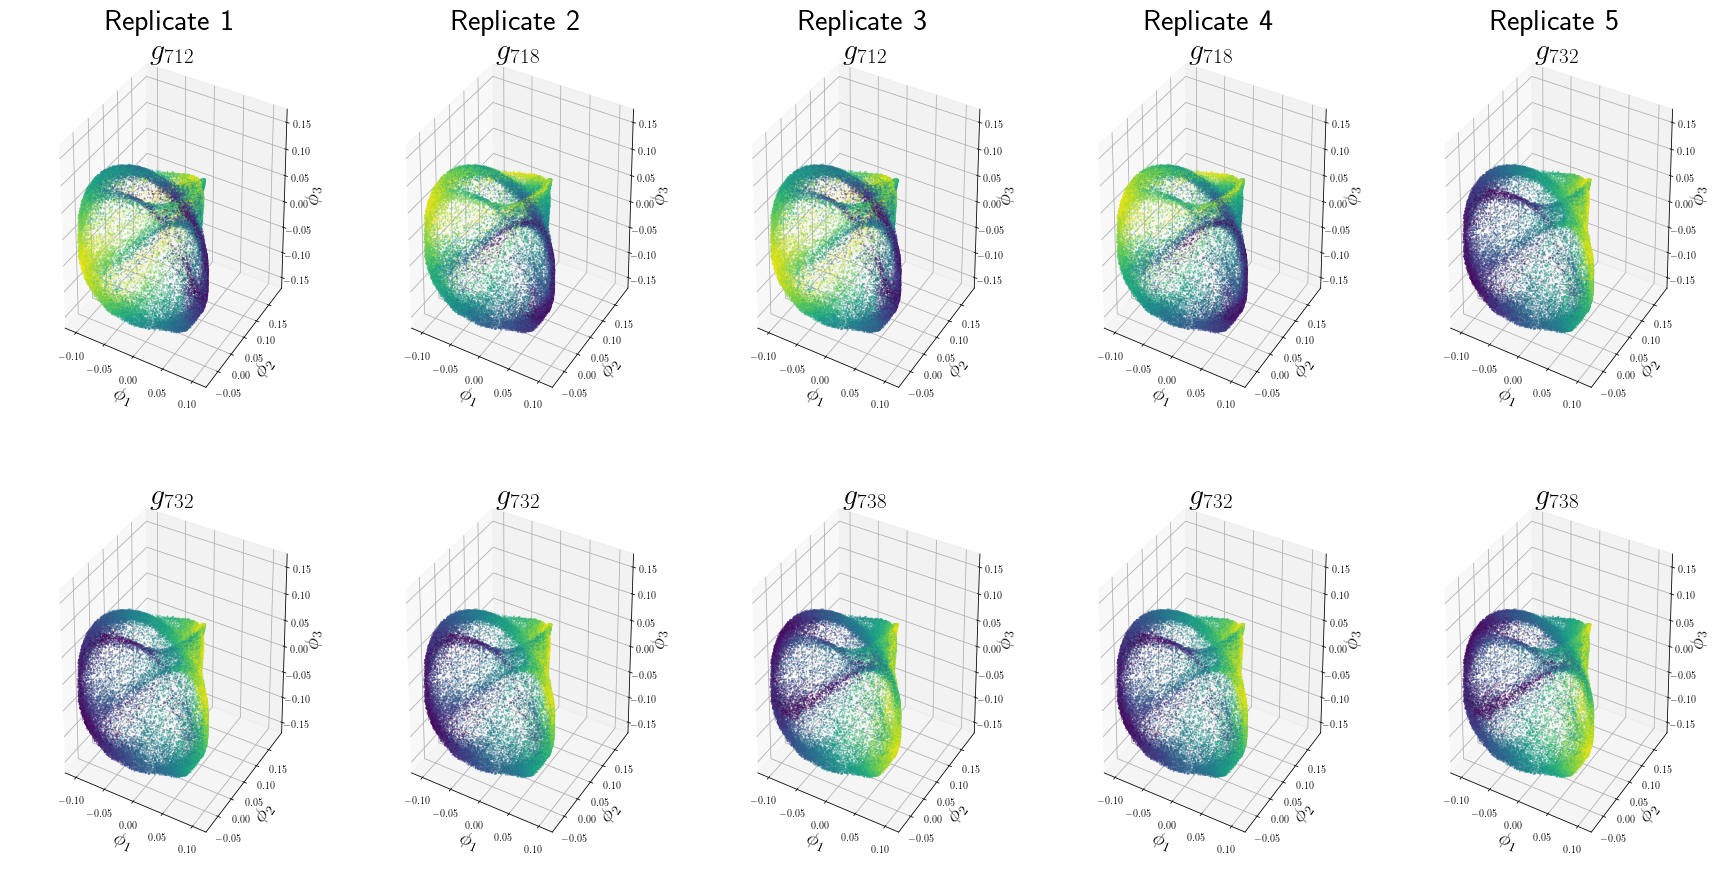

In [45]:
%matplotlib inline
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

fig, axs = plt.subplots(2,5, figsize = (30,15))

for r in range(5):
    for o in range(2):
        axs[o,r].set_axis_off()
data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]
for r in range(5):
    for o in range(2):
        ax = fig.add_subplot(2,5, o*5 + r + 1, projection='3d')
        #fig = plt.figure(figsize=(15,10))
        #ax = fig.add_subplot(1, 1, 1, projection='3d')
        ax.scatter(x, y, z, c = g_mf[r,o], s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
        ax.set_xlabel(r'$\phi_1$', fontsize = 20)
        ax.set_ylabel(r'$\phi_2$', fontsize = 20)
        ax.set_zlabel(r'$\phi_3$', fontsize = 20)
        
        if o ==0:
            ax.set_title('Replicate ' + str(r+1) + '\n' + r'$g_{{{}}}$'.format(sel[r][0]))
        if o == 1:
            ax.set_title(r'$g_{{{}}}$'.format(sel[r][1])        )
        #ax.set_title(r'$g_{{{}}}$'.format(sel[r][o]), fontsize = 20)
            
#     if r ==0:
#         if o == 0:
#             ax.set_ylabel('Support', fontsize = 20)
        #ax.set_axis_off()
    
plt.savefig('mal_full_sup_mflasso')